In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
# from skymapper import Map, projection

from time import time
from icecream import ic

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files, scales

from deepsphere.healpy_layers import HealpySmoothing

In [3]:
with_lensing=True
with_clustering=True
apply_smoothing=True

In [4]:
# with_lensing=True
# with_clustering=False
# apply_smoothing=True

# v10

In [5]:
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/debug/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v10/linear_bias_octant/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/linear_bias/tfrecords/grid/DESy3stoch_grid_dmb_0111.tfrecord"
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/linear_bias/tfrecords/grid/DESy3_grid_dmb_0111.tfrecord"

# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias_debug.yaml"
# # conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias.yaml"
# # conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v10/linear_bias_octant.yaml"
# conf = files.load_config(conf)

# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# # filename_suffix = "_v10_octant"
# filename_suffix = ""

# v11

In [6]:
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/linear_bias/tfrecords/grid/DESy3_grid_dmb_0111.tfrecord"
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/linear_bias/tfrecords/grid/DESy3stoch_grid_dmb_0111.tfrecord"

# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/linear_bias/tfrecords/grid/DESy3per_bin_grid_dmb_0111.tfrecord"
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/linear_bias/tfrecords/grid/DESy3power_law_grid_dmb_0111.tfrecord"

# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/linear_bias/tfrecords/grid/DESy3extended_hard_grid_dmb_0111.tfrecord"
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/linear_bias/tfrecords/grid/DESy3extended_soft_grid_dmb_0111.tfrecord"

# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/extended_hard_cut/tfrecords/grid/DESy3_grid_dmb_0100.tfrecord"

# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v11/debug/extended.yaml"
# conf = files.load_config(conf)

# # params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg1", "bg2", "bg3", "bg4"]
# filename_suffix = ""

# v12

In [7]:
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v12/debug/DESy3_nonlinear_grid_dmb_0000.tfrecord"

# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v12/debug/nonlinear.yaml"
# conf = files.load_config(conf)

# params = ["Om", "s8", "Ob", "H0", "ns", "w0", 
#           "Aia", "n_Aia", 
#           "bg1", "bg2", "bg3", "bg4", "qbg1", "qbg2", "qbg3", "qbg4"]

# filename_suffix = ""

# v13

In [28]:
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v13/extended/tfrecords/grid/DESy3_grid_dmb_0000.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v13/debug/extended.yaml"
conf = files.load_config(conf)

params = [
    "Om", "s8", "Ob", "H0", "ns", "w0", 
    "Aia", "n_Aia", "bta",
    "bg1", "bg2", "bg3", "bg4",
]

filename_suffix = ""

In [29]:
grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_padding=True,
    apply_norm=False,
    # apply_norm=True,
    return_cls=False,
)

24-12-10 11:17:19     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-12-10 11:17:19     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [30]:
data_vec_pix = grid_pipe.data_vec_pix
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = 2

### smoothing

In [31]:
# dlss_conf = "/global/u2/a/athomsen/y3-deep-lss/configs/v8/combined/linear_bias/dlss_config.yaml"
# dlss_conf = input_output.read_yaml(dlss_conf)

# # dlss_conf = {
# #     "scale_cuts" : {
# #           "n_sigma_support": 3,
# #           "arcmin": True,
# #           "lensing": {
# #             # 6 Mpc/h transverse comoving scale -> arcmin
# #             "theta_fwhm": [22.1, 15.1, 11.2, 9.4]
# #           },
# #         "clustering" : {
# #             # 16 Mpc/h transverse comoving scale -> arcmin
# #             "theta_fwhm": [65.1, 44.5, 34.1, 28.5]
# #         },
# #     }
# # }

            
mask_dict = files.get_tomo_dv_masks(conf)
    
if with_lensing and with_clustering:
    mask = tf.concat([mask_dict["metacal"], mask_dict["maglim"]], axis=1)
elif with_lensing and not with_clustering:
    mask = mask_dict["metacal"]
elif not with_lensing and with_clustering:
    mask = mask_dict["maglim"]
else:
    raise ValueError("At least one of with_lensing and with_clustering must be True")
    
mask = mask.numpy()

# fwhm = []
# if with_lensing:
#     fwhm += dlss_conf["scale_cuts"]["lensing"]["theta_fwhm"]
# if with_clustering:
#     fwhm += dlss_conf["scale_cuts"]["clustering"]["theta_fwhm"]

# # fwhm = [30] * n_z
    
# smoothing_kwargs = {
#     "nside": n_side,
#     "indices": data_vec_pix,
#     "nest": True,
#     "mask": mask,
#     "fwhm": fwhm,
#     "arcmin": dlss_conf["scale_cuts"]["arcmin"],
#     # "n_sigma_support": dlss_conf["scale_cuts"]["n_sigma_support"],
#     "n_sigma_support": 5,
#     # naive
#     # "white_noise_sigma": [0.51520719, 0.35428238, 0.27699105, 0.26566648, 1.62299023, 0.81909851, 0.64732432, 0.73886103],
#     # 10%
#     # "white_noise_sigma": [0.39659172, 0.27256747, 0.21457003, 0.21277644, 1.09389987, 0.58061397, 0.46553319, 0.51377827],
#     # 1%
#     # "white_noise_sigma": [0.12516133, 0.08745182, 0.05437602, 0.09995155, 0.26904975, 0.14492357, 0.11769442, 0.12976879],
#     # 1% without normalization
#     # "white_noise_sigma": [0.00107639, 0.00119809, 0.00136985, 0.00326847, 0.26904975, 0.14492357, 0.11769442, 0.12976879],
#     # new 10% 
#     # "white_noise_sigma": [1.14565783, 0.80190855, 0.61765043, 0.53866129, 2.09900186, 1.34174446, 1.11619657, 1.30594977],
#     # new 5% 
#     "white_noise_sigma": [0.82754379, 0.55846101, 0.44516373, 0.53261196, 1.19988939, 0.82611261, 0.7374048, 0.84169528],
#     "data_path": ".",
# }

# mask = mask.astype(bool)

# smoothing_layer = tf.function(HealpySmoothing(**smoothing_kwargs))

24-12-10 11:17:21     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


### compare noise realizations to noiseless

In [32]:
# noisy_grid_dset = grid_pipe.get_dset(
#         tfr_pattern=tfr_pattern,
#         noise_indices=n_noise,
#         local_batch_size=10,
#         n_readers=1,
#         n_prefetch=0,
# )
# for tfr in noisy_grid_dset.take(1):
#     pass

# print(tfr[0].shape)
# print(tfr[1].shape)

In [33]:
noisy_grid_dset = grid_pipe.get_dset(
        tfr_pattern=tfr_pattern,
        noise_indices=n_noise,
        local_batch_size=1,
        n_readers=1,
        n_prefetch=0,
)

dvs = []
dvs_raw = []
for dv, cl, cosmo, index in noisy_grid_dset.take(n_noise):
    dvs_raw.append(dv)
    
    # print(cl.shape)
    
    # # apply smoothing
    # if apply_smoothing:
    #     dv = smoothing_layer(dv)
        
        # hp_map = np.zeros((hp.nside2npix(n_side), dv.shape[-1]))
        # hp_map[data_vec_pix] = dv[0]             
        # hp_map, _ = scales.map_to_smoothed_map(
        #     hp_map, 
        #     n_side=n_side,
        #     l_min=[0]*n_z,
        #     theta_fwhm=fwhm,
        #     arcmin=dlss_conf["scale_cuts"]["arcmin"],
        #     nest=True
        # )        
        # dv = hp_map[data_vec_pix]
        # dv = dv[np.newaxis]
        
    dvs.append(dv)
    
dvs = np.concatenate(dvs, axis=0)
dvs_raw = np.concatenate(dvs_raw, axis=0)
print(dvs.shape)

24-12-10 11:17:23 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-12-10 11:17:23 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-12-10 11:17:23 grid_pipelin INF   Including noise_indices = [0, 1] 
24-12-10 11:17:23 grid_pipelin INF   Interleaving with n_readers = 1 
dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg'])
24-12-10 11:17:23 grid_pipelin INF   Batching into 1 elements locally 
24-12-10 11:17:23 grid_pipelin WAR   Tracing _augmentations 
24-12-10 11:17:23 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg', 'i_noise']) 
24-12-10 11:17:23 grid_pipelin INF   Successfully generated the grid validation set with element_spec (TensorSpec(shape=(None, 460800, 8), dtype=tf.float32, name=None), NoneTensorSpec(), TensorSpec(shape=(None, 13), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorS

In [34]:
for dv, cl, cosmo, index in noisy_grid_dset.take(10):
    print(cosmo)

tf.Tensor(
[[ 3.0000001e-01  8.9999998e-01  4.5000002e-02  7.3000000e+01
   9.7000003e-01 -1.1665000e+00 -2.3694303e+00 -2.8343084e+00
   1.2243915e-01  2.1738636e+00  2.6003377e+00  8.7474805e-01
   2.1332939e+00]], shape=(1, 13), dtype=float32)
tf.Tensor(
[[ 3.0000001e-01  8.9999998e-01  4.5000002e-02  7.3000000e+01
   9.7000003e-01 -1.1665000e+00 -2.3694303e+00 -2.8343084e+00
   1.2243915e-01  2.1738636e+00  2.6003377e+00  8.7474805e-01
   2.1332939e+00]], shape=(1, 13), dtype=float32)
tf.Tensor(
[[ 3.0000001e-01  8.9999998e-01  4.5000002e-02  7.3000000e+01
   9.7000003e-01 -1.1665000e+00 -3.2428062e-01  2.0511720e-01
   8.7905794e-01  1.9814100e+00  1.7623117e+00  1.1535535e+00
   2.1039410e+00]], shape=(1, 13), dtype=float32)
tf.Tensor(
[[ 3.0000001e-01  8.9999998e-01  4.5000002e-02  7.3000000e+01
   9.7000003e-01 -1.1665000e+00 -3.2428062e-01  2.0511720e-01
   8.7905794e-01  1.9814100e+00  1.7623117e+00  1.1535535e+00
   2.1039410e+00]], shape=(1, 13), dtype=float32)
tf.Tensor(
[

In [35]:
# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

# # DES footprint
rot = (90, -30, 0)

# octant
# rot = (10, 10, 0)

gnoms = np.zeros((len(dvs), x_pix, y_pix, n_z))
gnoms_raw = np.zeros((len(dvs), x_pix, y_pix, n_z))

for i_n in range(len(dvs)):
    for i_z in range(n_z):
        # default
        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = dvs[i_n,:,i_z]

        gnom = hp.gnomview(hp_map, nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
        gnoms[i_n, ..., i_z] = gnom

        # raw
        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = dvs_raw[i_n,:,i_z]

        gnom_raw = hp.gnomview(hp_map, nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
        gnoms_raw[i_n, ..., i_z] = gnom_raw

gnoms = np.ma.masked_where(gnoms==0, gnoms)
gnoms_raw = np.ma.masked_where(gnoms_raw==0, gnoms_raw)

### raw maps

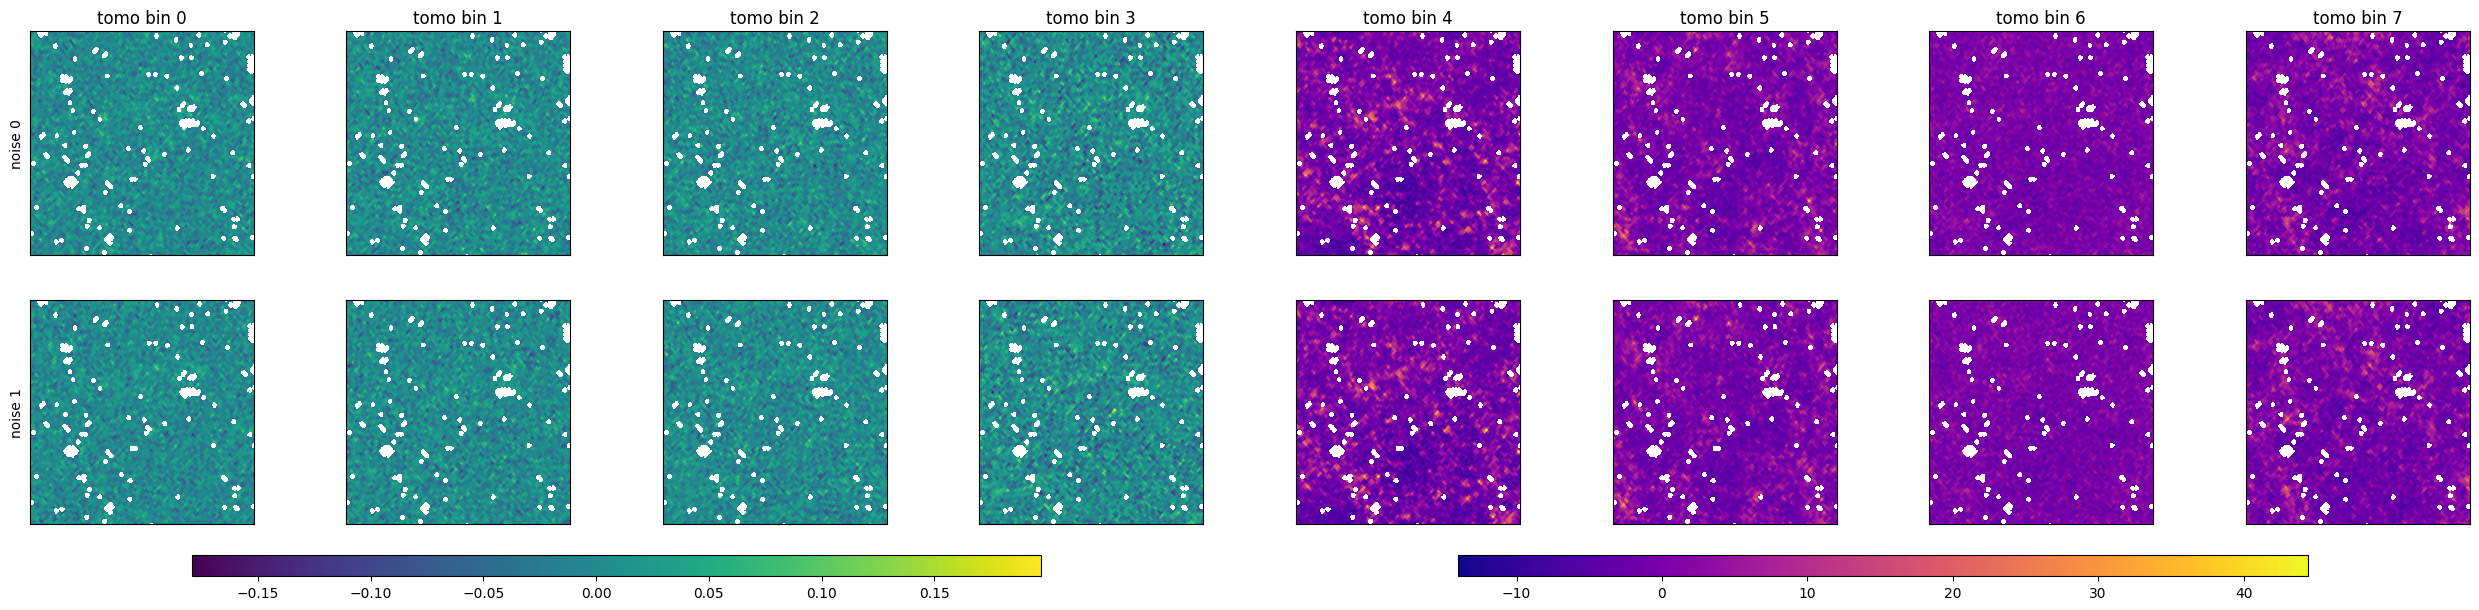

In [36]:
fig, ax = plt.subplots(figsize=(4*n_z, 4*n_noise), nrows=n_noise, ncols=n_z)

wl_min = np.array(gnoms[...,:n_z_metacal]).min()
wl_max = np.array(gnoms[...,:n_z_metacal]).max()

gc_min = np.array(gnoms[...,n_z_metacal:]).min()
gc_max = np.array(gnoms[...,n_z_metacal:]).max()

for i_n  in range(n_noise):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            
            # vmin = -4
            # vmax = 5

            cmap = "plasma"

        gnom = gnoms[i_n, ..., i_z]

        im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

        ax[i_n, i_z].set_xticks([])
        ax[i_n, i_z].set_yticks([])
        ax[i_n, i_z].set_aspect("equal")
        
        if i_z == 0:
            ax[i_n, i_z].set(ylabel=f"noise {i_n}")
            
        if i_n == 0:
            ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
        if i_n == n_noise - 1:
            if i_z == 0:
                fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
            if i_z == 4:
                fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
fig.savefig("plots/gnom_maps" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

In [37]:
# fig, ax = plt.subplots(figsize=(6*n_z, 4), ncols=n_z, sharex=True, sharey=True)

# i_noise = 0

# for i in range(n_z):
#     # multiple noise realizations
#     # dv_noisy = dvs[...,i]
#     # dv_noisy = dv_noisy.ravel()

#     # single noise realization
#     dv_noisy = dvs[i_noise,:,i]
#     dv_noisy = dv_noisy[mask[:,i]]
    
#     dv_noisy = (dv_noisy - np.mean(dv_noisy))/np.std(dv_noisy)
    
#     # print(np.mean(dv_noisy), np.std(dv_noisy), skew(dv_noisy), kurtosis(dv_noisy))
    
#     ax[i].hist(dv_noisy, np.linspace(-4, 4, 50), density=True)
#     # ax[i].hist(dv_noisy[dv_noisy!=0], np.linspace(-4, 4, 50), density=True)

#     ax[i].set(title=f"mu = {np.mean(dv_noisy):.2f}, sigma = {np.std(dv_noisy):.2f}, skew = {skew(dv_noisy):.2f}", xlabel=f"bin {i}")
#     ax[i].grid(True)
    
# fig.savefig("plots/clustering_hist" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### raw vs. smoothed

In [38]:
# fig, ax = plt.subplots(figsize=(4*n_z, 4*2), nrows=2, ncols=n_z)

# wl_min = np.array(gnoms[...,:n_z_metacal]).min()
# wl_max = np.array(gnoms[...,:n_z_metacal]).max()
# wl_min_raw = np.array(gnoms_raw[...,:n_z_metacal]).min()
# wl_max_raw = np.array(gnoms_raw[...,:n_z_metacal]).max()

# gc_min = np.array(gnoms[...,n_z_metacal:]).min()
# gc_max = np.array(gnoms[...,n_z_metacal:]).max()
# gc_min_raw = np.array(gnoms_raw[...,n_z_metacal:]).min()
# gc_max_raw = np.array(gnoms_raw[...,n_z_metacal:]).max()

# i_n = 0
# for i_z in range(n_z):
#     # lensing
#     if i_z < n_z_metacal:
#         vmin = wl_min
#         vmax = wl_max
#         vmin_raw = wl_min_raw
#         vmax_raw = wl_max_raw

#         cmap = "viridis"

#     # clustering
#     else:
#         vmin = gc_min
#         vmax = gc_max
#         vmin_raw = gc_min_raw
#         vmax_raw = gc_max_raw

#         cmap = "plasma"

#     # plotting
#     im_raw = ax[0, i_z].imshow(gnoms_raw[i_n, ..., i_z], vmin=vmin_raw, vmax=vmax_raw, cmap=cmap)
#     im = ax[1, i_z].imshow(gnoms[i_n, ..., i_z], vmin=vmin, vmax=vmax, cmap=cmap)

#     # if i_z == 0:
#     #     fig.colorbar(im_raw, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
#     # if i_z == 4:
#     #     fig.colorbar(im_raw, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)

#     if i_z == 0:
#         fig.colorbar(im_raw, ax=ax[0,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
#         fig.colorbar(im, ax=ax[1,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)

#     if i_z == 4:
#         fig.colorbar(im_raw, ax=ax[0,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
#         fig.colorbar(im, ax=ax[1,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)

#     for i in range(2):
#         ax[i, i_z].set_xticks([])
#         ax[i, i_z].set_yticks([])
#         ax[i, i_z].set_aspect("equal")

    
# for i, bin_number in enumerate(range(1,5)):
#     ax[0, i].set(title=f"metacalibration bin {bin_number}")
    
# for i, bin_number in enumerate(range(1,5)):
#     ax[0, i+4].set(title=f"maglim bin {bin_number}")
                
# fig.savefig("plots/gnom_raw_vs_smoothed" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

In [39]:
# fig, ax = plt.subplots(figsize=(4*n_z, 4*2), nrows=2, ncols=n_z)

# wl_min = np.array(gnoms_raw[...,:n_z_metacal]).min()
# wl_max = np.array(gnoms_raw[...,:n_z_metacal]).max()

# gc_min = np.array(gnoms_raw[...,n_z_metacal:]).min()
# gc_max = np.array(gnoms_raw[...,n_z_metacal:]).max()

# i_n = 0
# for i_z in range(n_z):
#     # lensing
#     if i_z < n_z_metacal:
#         vmin = wl_min
#         vmax = wl_max

#         cmap = "viridis"

#     # clustering
#     else:
#         vmin = gc_min
#         vmax = gc_max

#         cmap = "plasma"

#     # plotting
#     im_raw = ax[0, i_z].imshow(gnoms_raw[i_n, ..., i_z], vmin=vmin, vmax=vmax, cmap=cmap)
#     im = ax[1, i_z].imshow(gnoms[i_n, ..., i_z], vmin=vmin, vmax=vmax, cmap=cmap)

#     if i_z == 0:
#         fig.colorbar(im_raw, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
#     if i_z == 4:
#         fig.colorbar(im_raw, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)

#     for i in range(2):
#         ax[i, i_z].set_xticks([])
#         ax[i, i_z].set_yticks([])
#         ax[i, i_z].set_aspect("equal")

    
# for i, bin_number in enumerate(range(1,5)):
#     ax[0, i].set(title=f"metacalibration bin {bin_number}")
    
# for i, bin_number in enumerate(range(1,5)):
#     ax[0, i+4].set(title=f"maglim bin {bin_number}")
                
# fig.savefig("plots/gnom_raw_vs_smoothed" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### differences to noise 0

In [40]:
# fig, ax = plt.subplots(figsize=(4*n_z, 4*(n_noise - 1)), nrows=n_noise - 1, ncols=n_z)

# for i_n in range(n_noise - 1):
#     for i_z in range(n_z):
#         # lensing
#         if i_z < n_z_metacal:
#             vmin = wl_min
#             vmax = wl_max
#             cmap = "viridis"

#         # clustering
#         else:
#             vmin = gc_min
#             vmax = gc_max
#             cmap = "plasma"

#         gnom = gnoms[i_n+1, ..., i_z] - gnoms[0, ..., i_z]
#         im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

#         ax[i_n, i_z].set_xticks([])
#         ax[i_n, i_z].set_yticks([])
#         ax[i_n, i_z].set_aspect("equal")
        
#         if i_z == 0:
#             ax[i_n, i_z].set(ylabel=f"noise {i_n+1} - noise 0")
            
#         if i_n == 0:
#             ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
#         if i_n == n_noise - 2:
#             if i_z == 0:
#                 fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
#             if i_z == 4:
#                 fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
# fig.savefig("plots/gnom_noise_diff" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### mollview

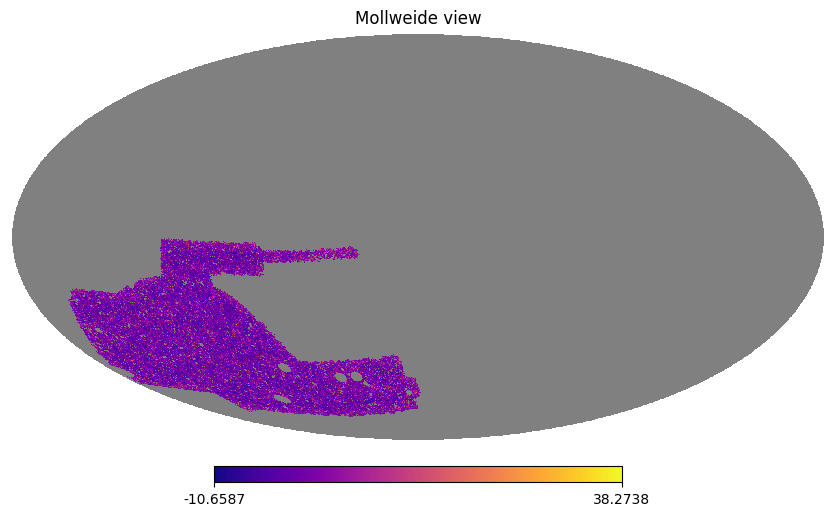

In [41]:
i_noise = 0
i_z = 7

hp_map = np.full(n_pix, hp.UNSEEN)
hp_map[data_vec_pix] = dvs[i_n,:,i_z]
hp_map[hp_map==0] = hp.UNSEEN

hp.mollview(hp_map, nest=True, cmap="plasma", xsize=2000)
plt.savefig(f"plots/moll_map_bin{i_z}" + filename_suffix + ".png", bbox_inches="tight", dpi=500)

In [42]:
# wl_min = np.array(dvs[...,:n_z_metacal]).min()
# wl_max = np.array(dvs[...,:n_z_metacal]).max()

# gc_min = np.array(dvs[...,n_z_metacal:]).min()
# gc_max = np.array(dvs[...,n_z_metacal:]).max()

# plt.figure(figsize=(4*n_z,2*n_noise))

# i_subplot = 1
# for i_n  in range(n_noise):
#     for i_z in range(n_z):
#         # lensing
#         if i_z < n_z_metacal:
#             vmin = wl_min
#             vmax = wl_max
#             cmap = "viridis"

#         # clustering
#         else:
#             vmin = gc_min
#             vmax = gc_max
#             cmap = "plasma"
            
#         if i_n == 0:
#             title = f"tomo bin {i_z}"
#         else:
#             title = ""

#         hp_map = np.full(n_pix, hp.UNSEEN)
#         hp_map[data_vec_pix] = dvs[i_n,:,i_z]
        
#         hp.mollview(hp_map, nest=True, cmap=cmap, sub=(n_noise,n_z,i_subplot), xsize=2000, title=title, min=vmin, max=vmax)
#         i_subplot += 1

# plt.savefig("plots/moll_maps" + filename_suffix + ".png", bbox_inches="tight", dpi=500)

# noise index selection

In [43]:
# noise_indices = 3
# noise_indices = [0, 2]
# n_noise = noise_indices if isinstance(noise_indices, int) else len(noise_indices)

# temp_dset = grid_pipe.get_dset(
#         tfr_pattern=tfr_pattern,
#         noise_indices=noise_indices,
#         local_batch_size=1,
#         n_readers=1,
#         n_prefetch=0,
# )

# i_z = 5
# for dv, cosmo, index in temp_dset.take(3*n_noise):
#     print(index[2])

#     hp_map = np.zeros(n_pix)
#     hp_map[data_vec_pix] = dv[0,:,i_z]
    
#     # smoothing to reduce the effect of noise, since it's always included for the grip pipe
#     hp_map = hp.smoothing(hp_map, fwhm=0.01, nest=True)
    
#     hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=False, no_plot=False)
